# توجه 

1. به راهنمایی هایی که در کد آمده است توجه کنید
2. مواردی که به صورت "#TODO"
را باید بصورتی که در صورت پروژه تعریف شده است انجام دهید. 

In [2]:
! pip install hazm
! pip install gensim==4.1.2
!pip install words
!pip install elasticsearch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from elasticsearch import Elasticsearch
from elasticsearch import helpers
import json
from tqdm import tqdm
from gensim.models import Word2Vec
import numpy as np
import random
import pandas as pd
# import whatever you need for your implementation  

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


# step 1 
داده هایی که در اختیار دارید را بارگذاری کنید و مشابه بخش های قبل پیش پردازش های لازم را انجام دهید. 
مطابق فازهای و بخش های پیشین پروژه مراحل پیش پردازش را انجام دهید. در نهایت لیست از اسناد بسازید که برای هر متن شامل توکن های آن متن باشد. 
این لیست میتواند ساختاری مطابق تصویر زیر داشته باشد.
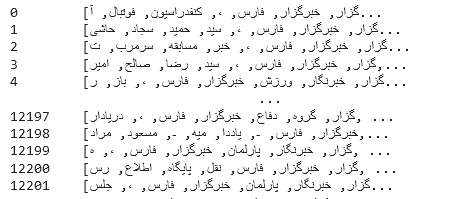

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np

In [6]:
from __future__ import unicode_literals
from hazm import *

In [12]:
train_for_vec = pd.read_excel("/content/drive/MyDrive/IR_P3/IR01_3_46k.xlsx")

In [13]:
normalizer = Normalizer()
train_vec = []
for i in range(len(train_for_vec)):
  c = word_tokenize(normalizer.normalize(train_for_vec["content"][i]))
  train_vec.append(c)

# گام دوم 
در این گام شما باید بتوانید که هر سند را به یک بردار عددی تبدیل کنید. این کار را به کمک ماژول آماده ایی که در اختیار شما قرار گرفته است انجام می شود.
بدین منظور مراحل زیر را انجام دهید. 










دو بلوک بعدی کد برای استفاده از ماژول آماده تهیه شده و صرفا به شکل مثال نوشته شده اند، ممکن است برای استفاده عملی در پروژه نیاز به تغییر باشد. 

In [14]:
from typing import List
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from pathlib import Path



class DocToVec:
    
    def __init__(self, dataset:List[List] , vec_size = 200 , model_path = 'word2vec.model'):
        """ Here we train our model and calculate tf-idf weights.

        Args:
            dataset (List[List]): Each item of this list is a list of tokens obtained from a document.
            vec_size (int, optional): The size of the vector of each document. Defaults to 200.
            model_path (str, optional): The path of pre-trained model. If there is no file in the specified 
            path, It trains a model with the dataset and saves the trained model. Defaults to 'word2vec.model'.
        """

        self.vec_size = vec_size
        
        
        
        if not Path(model_path).is_file():
            print('There is no pre-trained model. Going to train a model ...')
            self.wordToVecModel = Word2Vec(
                window = 10,
                min_count=2,
                workers=4,
                vector_size = self.vec_size
            )
        
            self.wordToVecModel.build_vocab(dataset)
            
            self.wordToVecModel.train(
                dataset,
                total_examples = self.wordToVecModel.corpus_count,
                epochs = 20,
            )
            
            self.wordToVecModel.save(model_path)
            
        else:
            
            print('Loading the model ...')
            self.wordToVecModel = Word2Vec.load(model_path)
        
        con_train_data = [" ".join(a) for a in dataset]
        
        self.tfIdfVectorizer=TfidfVectorizer(use_idf=True,
                                        dtype = np.float64,
                                        lowercase = False,
                                        vocabulary = self.wordToVecModel.wv.index_to_key)
        
        self.tfIdfVectorizer.fit(con_train_data)
        
        dictionary = self.tfIdfVectorizer.get_feature_names()
        self.dictToNum = {d:i for i,d in enumerate(dictionary)}
        
        
    def embed(self, tokens:List):
        """Maps the input to a vector

        Args:
            tokens (List): List of tokens (don't forget to do preprocessing before 
            extracting tokens)

        Returns:
            Numpy Array: The vector of document
        """
        
        ti = self.tfIdfVectorizer.transform([" ".join(tokens)])
        
        weights = np.squeeze(np.asarray(ti[0].T.todense()))
        
        vec = np.zeros((self.vec_size,))
        sum_weights = 0
        for k in set(tokens):
            try:
                word_vec = self.wordToVecModel.wv[k]
                weight = weights[self.dictToNum[k]]
                vec += word_vec * weight
                sum_weights += weight
            except KeyError:
                pass
        vec /= sum_weights
        return vec

In [16]:
# dataset: each document is a list of its tokens. 
# model_path: is a path that you want save model in it. 
doc2vec = DocToVec (train_vec , vec_size = 200 , model_path = '/content/drive/MyDrive/IR_P3/word2vec.model')

There is no pre-trained model. Going to train a model ...


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# ابتدا بردارهای عددی داده های تست را بدست آورده و سپس از این بردارها برای تولید بردار  بقیه ی داده ها استفاده کنید. 

In [17]:
mapping = { 
    "mappings": {
        "properties": {
          "content": {
            "type": "text"
          },
            "category":{
                "type": "keyword"
            },
            "vec":{
                "type": "dense_vector",
                "dims": 200,
                "index": True,
                "similarity": "cosine"
            }
        }
    }
}

In [18]:
ELASTIC_PASSWORD = "6RcaBqaCzfoPaoERT95g1Jwl"

# Found in the 'Manage Deployment' page
CLOUD_ID = "deployment-name:dXMtZWFzdDQuZ2Nw..."

# Create the client instance
es = Elasticsearch(
    cloud_id="th3amirrj:dXMtY2VudHJhbDEuZ2NwLmNsb3VkLmVzLmlvOjQ0MyQzOTBjODA5YjIwOGI0NGI3OGZlNWI4Y2JhMjhiMzViOSRjZjUxOGIyYmQ4OTk0NDJmOGJlNzBhZTIxOTY0ZDQ5NA==",
    basic_auth=("elastic", ELASTIC_PASSWORD)
)

In [19]:
import random
index_name = f"ir_knn_{random.randint(10000, 11000)}"
index_name

'ir_knn_10003'

In [20]:
# Delete index if one does exist
if es.indices.exists(index=index_name):
    es.indices.delete(index=index_name)

# Create index
es.indices.create(index=index_name, body=mapping)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  


ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'ir_knn_10003'})

In [21]:
trainig_set = pd.read_excel("/content/drive/MyDrive/IR_P3/IR01_3_test_4k.xlsx")
Cs = list(trainig_set["category"].unique())

In [26]:
Cs.remove('category')
Cs

['culture', 'economy', 'health', 'political', 'sport']

In [27]:
from copy import deepcopy
training_tmp = []
for i in tqdm(range(len(trainig_set))):
    if i==15:
      continue
    doc = dict()
    # filter_doc: method for preprocessing a doc. 
    doc['content'] = trainig_set['content'][i]
    doc['vec'] = list(doc2vec.embed(word_tokenize(normalizer.normalize(trainig_set['content'][i]))))
    doc['category'] = trainig_set['category'][i]
    training_tmp.append(doc)

100%|██████████| 4022/4022 [00:26<00:00, 153.22it/s]


In [28]:
data_bulk = [
    {
        "_index" : index_name,
        "_id" : i + 1,
        "_source": training_tmp[i]
    }
    for i in range(len(training_tmp))
]
resp = helpers.bulk(
  es,
  data_bulk,
  index = index_name
)
print(resp)

(4021, [])


# گام سوم

در این بخش باید داده های تست را بارگذاری و پیش پردازش کنید و سپس برای هر متن بردار آن را بدست آورده و به روش  نزدیکترین همسایه جستجو را انجام داده و برچسب این سند را بدست آورید. 

In [29]:
test_dataset = pd.read_excel("/content/drive/MyDrive/IR_P3/IR01_3_46k.xlsx")

In [41]:
import operator
def find_C(ANS):
  ks = list(ANS.keys())
  index, max_ = 0, ANS[ks[0]]
  for i in range(1, len(ks)):
    if ANS[ks[i]] > max_:
      max_ = ANS[ks[i]]
      index = i
  return ks[index]

In [44]:
result = []
for i in tqdm(range(len(test_dataset))):
    vec = doc2vec.embed(word_tokenize(normalizer.normalize(test_dataset['content'][i])))    
    try:
        resp = es.knn_search(index=index_name,knn={
          #  TODO
          "field":"vec",
          "query_vector":vec,
          "k":11,
          "num_candidates":100
          }
          ,source=['content','category'],)
        cats = {
            'culture':0, 'economy':0, 'health':0, 'political':0, 'sport':0
        }
        for d in resp["hits"]["hits"]:
          cats[d["_source"]["category"]] += 1
        result.append(find_C(cats))

      # TODO;
    except Exception as e:
        # usualy happens when all the elements of 
        # the vector are zero.
        result.append("None")
        pass
len(result)

100%|██████████| 46769/46769 [15:31<00:00, 50.21it/s]


46769

In [45]:
test_dataset["category"] = result
test_dataset.to_csv("/content/drive/MyDrive/IR_P3/answer.csv", index=False)

In [46]:
downloaded_csv = pd.read_csv("/content/drive/MyDrive/IR_P3/answer.csv")
len(downloaded_csv)

46769

# گام چهارم 

حال که برای هر متن برچسب آن را بدست آورده اید. متون هر دسته را به نحوی از سایر دسته ها مجزا کنید و مطابق موارد خواسته شده در گزارش جستجو را در دسته های مختلف انجام دهید. 

In [47]:
index_culture = f"culture_{random.randint(0, 1000)}"
index_economy = f"economy_{random.randint(0, 1000)}"
index_health = f"health_{random.randint(0, 1000)}"
index_political =f"political_{random.randint(0, 1000)}"
index_sport = f"sport_{random.randint(0, 1000)}"

In [48]:
name2index = {
    "culture": index_culture,
    "economy": index_economy,
    "health": index_health,
    "political": index_political,
    "sport": index_sport
}

In [49]:
es.indices.create(index=index_culture)
es.indices.create(index=index_economy)
es.indices.create(index=index_health)
es.indices.create(index=index_political)
es.indices.create(index=index_sport)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'sport_940'})

In [50]:
def indexing(N, C):
  tmp = []
  for i in tqdm(range(len(downloaded_csv))):
      if downloaded_csv["category"][i] != C:
        continue
      doc = dict()
      doc['content'] = downloaded_csv['content'][i]
      doc['url'] = downloaded_csv['url'][i]
      tmp.append(doc)
  data_bulk = [
      {
          "_index" : N,
          "_id" : i + 1,
          "_source": tmp[i]
      }
      for i in range(len(tmp))
  ]
  resp = helpers.bulk(
    es,
    data_bulk,
    index = N
  )
  print(resp)

In [51]:
ks = list(name2index.keys())
ks

['culture', 'economy', 'health', 'political', 'sport']

In [52]:
for k in ks:
  indexing(name2index[k], k)

100%|██████████| 46769/46769 [00:00<00:00, 70538.47it/s]


(9418, [])


100%|██████████| 46769/46769 [00:00<00:00, 99242.04it/s]


(12943, [])


100%|██████████| 46769/46769 [00:00<00:00, 144267.39it/s]


(1899, [])


100%|██████████| 46769/46769 [00:00<00:00, 99755.96it/s] 


(11490, [])


100%|██████████| 46769/46769 [00:00<00:00, 102852.08it/s]


(11018, [])


In [53]:
9418 + 12943 + 1899 + 11490 + 11018

46768

In [54]:
len(downloaded_csv)

46769

In [56]:
downloaded_csv["category"].count()

46769

In [57]:
def get_query(text):
    body ={
    "query":{  
        "match" : {
            "content" : text

            }
        }
    }
    
    return body

In [58]:
def get_res(C, q):
  res=es.search(index=name2index[C], body=get_query(q))
  i, j = 0, 0
  while(j < len(res["hits"]["hits"]) and i < 5):
    print(res["hits"]["hits"][j]["_source"]["url"])
    i += 1
    j += 1

In [60]:
get_res("sport", "علی دایی گل")

https://www.farsnews.ir/news/13991211000308/نوستالوژی-AFC-از-آخرین-گل-ملی-دایی-عکس
https://www.farsnews.ir/news/14000101000098/تقدیرفیفا-از-اسطوره-فوتبال-ایران-دایی-در-هوا-غیرقابل-مهار-بود
https://www.farsnews.ir/news/14000111000020/سرانجام-پای-کریس-به-گل-باز-شد-رونالدو-نزدیک-تر-از-همیشه-به-رکورد-علی
https://www.farsnews.ir/news/13991202000119/رسانه-پرتغالی-طارمی-پرچم-یک-ملت-را-با-افتخار-به-اهتزاز-درآورد
https://www.farsnews.ir/news/13991130000008/طارمی-پنجمین-گلزن-ایرانی-تاریخ-لیگ-قهرمانان-اروپا


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  


In [64]:
get_res("economy", "ایران صادرات گاز")

https://www.farsnews.ir/news/13991206000117/صادرات-گاز-به-اروپا-سنگ-بزرگ-برای-نزدن-اولویت‌های-صادرات-گاز-ایران
https://www.farsnews.ir/news/13990331000166/وزارت-نفت-بازار-گاز-را-به-رقبا-باخته-است--بازخوانی-برنامه-خاک-خورده
https://www.farsnews.ir/news/13990519001074/دستاوردسازی-از-وعده‌های-محقق-نشده-روایتی-از-گل-به-خودی‌های-وزارت-نفت
https://www.farsnews.ir/news/13990224000333/در-سایه-انفعال-وزارت-نفت-LNG-آمریکا-جایگزین-گاز-ایران-در-بازار-ترکیه
https://www.farsnews.ir/news/13991010000472/ماجرای-کاهش-و-افزایش-صادرات-گاز-ایران-به-عراق-مطالبات-برقی-و-گازی


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  


In [66]:
get_res("health", "پزشک تجویز دازو کرونا")

https://www.isna.ir/news/99081107161/همه-ی-علامت-های-مشکوک-کرونا
https://www.isna.ir/news/99072317507/بستری-شدن-یک-بازیگر-در-بیمارستان-بخاطر-کرونا
https://www.isna.ir/news/99091813630/احتمال-ابتلای-شدیدتر-بهبودیافتگان-به-کرونا-وجود-دارد
https://www.farsnews.ir/news/13990818000175/نتیجه-۲-نوبت-تست-کرونای-رئیس-مجلس-منفی-شد
https://www.isna.ir/news/99070201354/چه-کسانی-نباید-واکسن-آنفلوآنزا-بزنند


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  
